In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pickle

In [4]:
with open('raw_data_20180918.pickle', 'rb') as handle:
    raw_data = pickle.load(handle)

In [6]:
kospi200 = pd.read_csv("./data/data.csv", encoding="cp949")
kospi200 = kospi200[kospi200.columns[:2]]
kospi200["종목코드"] = kospi200["종목코드"].map('{:06d}'.format)

name_dict = { i : j for i, j in zip(kospi200["종목명"], kospi200["종목코드"]) }
code_dict = { j : i for i, j in zip(kospi200["종목명"], kospi200["종목코드"]) }

In [8]:
class SimpleClient:
    
    def __init__(self, balance):
        self.balance = balance
        self.status = {}
        for code in raw_data.keys():
            self.status[name_dict[code]] = {'share':0, 'long_price':0}
        self.recoder = {}
        for code in raw_data.keys():
            self.recorder[name_dict[code]] = []
            
    def trade(self, date, stock_name, share, price, transaction='long'):
        self.recode(self, date, stock_name, share, price, transaction='long')
        if transaction.upper() == 'LONG':
            if self.balance > share*price:
                self.status[stock_name]['share'] += share
                self.balance -= share*price
                self.status[stock_name]['long_price'] = price
            else:
                return False
        else:
            if abs(price-self.status[stock_name]['long_price']) < balance:
                self.status[stock_name]['share'] -= share
                self.balance += share*(price-self.status[stock_name]['long_price'])
            else:
                return False
        
        
    def recode(self, date, stock_name, share, price, transaction='long'):
        keys = ['date', 'share', 'price', 'transaction']
        datas = [date, share, price, transaction]
        self.recoder[stock_name].append({key : data for key, data in zip(keys, datas)})
        
    

In [36]:
test = raw_data['005930'].loc['2012-01-02':'2018-07-31'][['Close','Y3']].copy()

In [37]:
test = test.assign(수익률 = test.Close / test.Close.shift(1))

In [38]:
test = test.fillna(0)

In [44]:
test = test.assign(transaction = (test['Y3']-test['Y3'].shift(1)).fillna(0) + test['Y3'])

In [48]:
test = test.assign(tx = test.transaction.replace({1.0:1,-1.0:1,0.0:0,2.0:0}))

In [51]:
test = test.assign(returns = test.tx*test.수익률)

In [56]:
test = test.assign(returns2 = test.returns.replace(0,1))

In [63]:
test = test.assign(cumreturn = test.returns2.cumprod())

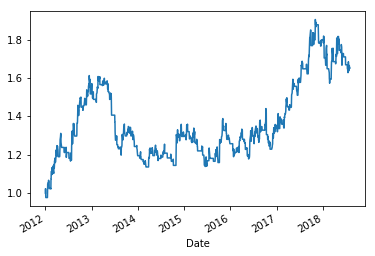

In [66]:
test.cumreturn.plot()

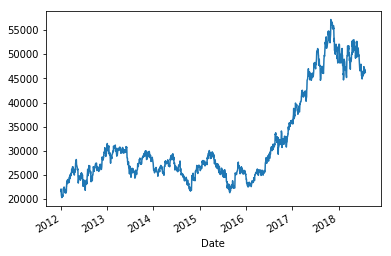

In [67]:
test.Close.plot()

In [88]:
def calc_return(stock_name, target, start, end):
    stock_code = name_dict[stock_name]
    test = raw_data[stock_code].loc[start:end][['Close',target]].copy()
    test = test.assign(수익률 = test.Close / test.Close.shift(1))
    test = test.fillna(0)
    test = test.assign(transaction = (test[target]-test[target].shift(1)).fillna(0) + test[target])
    test = test.assign(tx = test.transaction.replace({1.0:1,-1.0:1,0.0:0,2.0:0}))
    test = test.assign(returns = test.tx*test.수익률)
    test = test.assign(returns2 = test.returns.replace(0,1))
    test = test.assign(cumreturn = test.returns2.cumprod())
    test = test.assign(real_money = (test.Close.diff(1).fillna(0)*test.tx).cumsum())
    return test

In [89]:
start = '2012-01-02'
end = '2018-07-31'

In [90]:
test2 = calc_return('SK하이닉스', 'Y3', start, end)

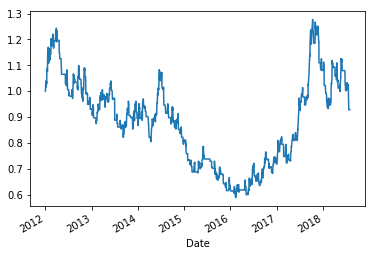

In [91]:
test2.cumreturn.plot()

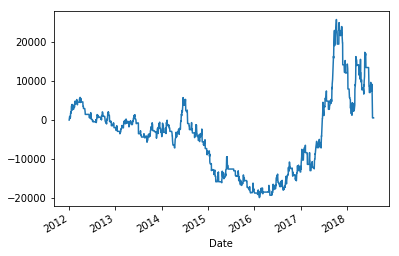

In [92]:
test2.real_money.plot()

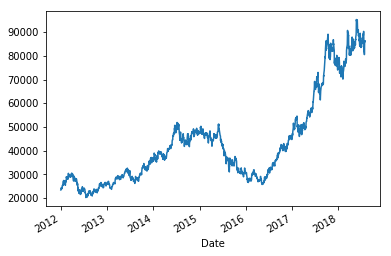

In [71]:
test2.Close.plot()

In [73]:
test.head()

,Close,Y3,수익률,transaction,tx,returns,returns2,cumreturn
Date,,,,,,,,
2012-01-02,21600.0,1,0.000000,1.0,1.0,0.000000,1.000000,1.000000
2012-01-03,22100.0,1,1.023148,1.0,1.0,1.023148,1.023148,1.023148
2012-01-04,21600.0,1,0.977376,1.0,1.0,0.977376,0.977376,1.000000
2012-01-05,21100.0,0,0.976852,-1.0,1.0,0.976852,0.976852,0.976852
2012-01-06,20800.0,0,0.985782,0.0,0.0,0.000000,1.000000,0.976852


In [198]:
test.iloc[0].Close

21600.0

In [87]:
(10000000/50) // test.loc['2012-01-02', 'Close']

9.0

In [100]:
1264 / 7 - 1264 // 7

0.5714285714285836

In [228]:
str(t.index[0])[:10] == '2014-04-23'

True

In [219]:
t = calc_return('현대로템', 'Y3', start, end)

In [230]:
def calc_return(stock_name, target, start, end):
    stock_code = name_dict[stock_name]
    try:
        test = raw_data[stock_code].loc[start:end][['Close',target]].copy()
    except KeyError:
        test = raw_data[stock_code].loc[:end][['Close',target]].copy()
    test = test.assign(수익률 = test.Close / test.Close.shift(1))
    test = test.fillna(0)
    test = test.assign(transaction = (test[target]-test[target].shift(1)).fillna(0) + test[target])
    test = test.assign(tx = test.transaction.replace({1.0:1,-1.0:1,0.0:0,2.0:0}))
    test = test.assign(returns = test.tx*test.수익률)
    test = test.assign(returns2 = test.returns.replace(0,1))
    test = test.assign(cumreturn = test.returns2.cumprod())
    test = test.assign(real_money = (test.Close.diff(1).fillna(0)*test.tx).cumsum())
    return test

class Portfolio:
    
    def __init__(self, asset, stock_list, start, end, target):
        self.asset = asset
        self.stock_list = stock_list
        self.portfolio = {}
        self.share = {}
        self.start = start
        for stock in stock_list:
            self.portfolio[stock] = calc_return(stock, target, start, end)
            self.share[stock] = (self.asset / len(stock_list)) / self.portfolio[stock].iloc[0].Close
        
    def union(self):
        total_return = pd.Series(index = self.portfolio[self.stock_list[0]].index).fillna(0)
        cash = 0
        for stock in self.stock_list:
            if str(self.portfolio[stock].index[0])[:10] != self.start:
                real_money = self.portfolio[stock].real_money.copy()
                real_money = (pd.Series(index = self.portfolio[self.stock_list[0]].index).fillna(0) + real_money).fillna(0)
                total_return += real_money * round(self.share[stock])
            else:
                total_return += self.portfolio[stock].real_money * round(self.share[stock])
            cash += self.portfolio[stock].iloc[0].Close * (self.share[stock] - int(self.share[stock]))
        return total_return, cash

In [200]:
del_li = ['BGF리테일', 'HDC현대산업개발', 'SK케미칼', '넷마블', '두산밥캣', '삼성바이오로직스', '오리온', '현대중공업지주', '효성중공업'] 

In [175]:
del_li2 = ['BGF', 'HDC', 'SK디스커버리', '대우조선해양', '대한항공', '동아쏘시오홀딩스', '동양', '롯데지주', '오리온홀딩스', '우리은행', '쿠쿠홀딩스', '팬오션', '한국타이어월드와이드', '한라홀딩스', '현대중공업', '효성'] 

In [184]:
party_df = pd.read_csv('party_df.csv')
party_df["종목코드"] = party_df["종목코드"].map('{:06d}'.format)
party = party_df[[code_dict[i] not in del_li for i in party_df.loc[:,'종목코드']]]
party = party[[code_dict[i] not in del_li2 for i in party.loc[:,'종목코드']]]

In [252]:
len(party)

177

In [247]:
party.income.value_counts()

middle          46
low             42
lower middle    40
high            29
upper middle    20
Name: income, dtype: int64

In [264]:
party[party.종목명=='한일홀딩스']

,업종,영문코드,종목명,종목코드,시가총액,income
144,건설,HHDS,한일홀딩스,003300,1082752415500,lower middle


In [266]:
party.loc[144, '종목명'] = '한일시멘트'

In [261]:
'003300' in code_dict.keys()

True

In [262]:
code_dict['003300']

'한일시멘트'

In [270]:
party.업종.value_counts()

경기소비재    35
생활소비재    32
에너지화학    22
금융       16
헬스케어     16
정보기술     15
산업재      13
건설       11
철강소재     10
중공업       7
Name: 업종, dtype: int64

In [404]:
port1 = Portfolio(10000000, party.종목명.tolist(), '2015-03-17', end, 'Y3')

In [405]:
total_return, cash = port1.union()

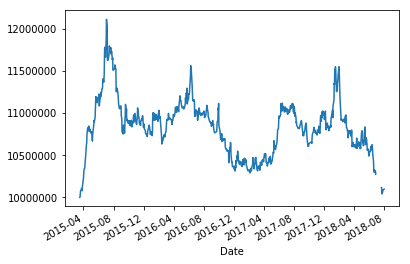

5737811.332504011

In [406]:
fig, ax = plt.subplots()
ax.get_yaxis().get_major_formatter().set_scientific(False)
(total_return+port1.asset).plot()
plt.show()
cash

In [278]:
party[party.종목명 == '한미사이언스']

,업종,영문코드,종목명,종목코드,시가총액,income
60,헬스케어,HANMIS,한미사이언스,008930,4400499203100,middle


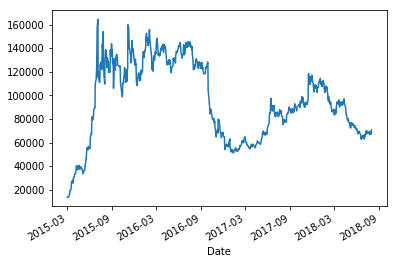

In [166]:
raw_data[name_dict['한미사이언스']].loc['2015-03-01':].Close.plot()

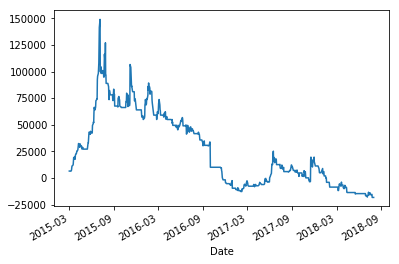

In [162]:
port1.portfolio['한미사이언스'].loc['2015-03-01':].real_money.plot()

In [324]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

In [373]:
df = yf.download("^KS11", start="2011-01-01", end="2018-08-01")

[*********************100%***********************]  1 of 1 downloaded


In [383]:
try:
    df2 = yf.download("^KS200", start="2011-01-01", end="2018-08-01")
except ValueError:
    print("ValueError")

[*********************100%***********************]  1 of 1 downloaded
ValueError


In [378]:
def for_loop_code(raw_data):
    for code in raw_data.keys():
        add_feature(raw_data[code])

def add_feature(data):
    """
    X
    """
    data["pct_change"] = data.Close.pct_change()
    for i in range(3, 31):
        data["close_ma_{}".format(i)] = data.Close.rolling(window = i).mean()
        data["volume_ma_{}".format(i)] =  data.Volume.rolling(window = i).mean()
    for i in [7, 21, 30, 60, 90, 91, 100, 120]:
        data["his_vol_{}".format(i)] = data["pct_change"].rolling(window = i).std()*(252**0.5)
    """
    Y
    """

    data['Y1'] = data.Close - data.close_ma_7.shift(1)
    data['Y2'] = data["pct_change"] - data["pct_change"].rolling(window = 7).mean().shift(1)
    data['Y3'] = data.Close.rolling(window=7).mean() - data.Close.shift(1).rolling(window=7).mean()

    data['Y1'] = np.where(data.Y1>=0, 1, 0)
    data['Y2'] = np.where(data.Y2>=0, 1, 0)
    data['Y3'] = np.where(data.Y3>=0, 1, 0)
    """
    Drop NaN
    """
    data = data.dropna(axis=0)

In [379]:
add_feature(df)

In [384]:
df

,Open,High,Low,Close,Adj Close,Volume,pct_change,close_ma_3,volume_ma_3,close_ma_4,...,his_vol_21,his_vol_30,his_vol_60,his_vol_90,his_vol_91,his_vol_100,his_vol_120,Y1,Y2,Y3
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,2063.689941,2070.090088,2054.830078,2070.080078,2070.080078,348200,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2011-01-04,2074.560059,2085.139893,2069.120117,2085.139893,2085.139893,411000,0.007275,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2011-01-05,2083.100098,2087.139893,2076.919922,2082.550049,2082.550049,383000,-0.001242,2079.256673,380733.333333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2011-01-06,2094.350098,2096.649902,2066.100098,2077.610107,2077.610107,405400,-0.002372,2081.766683,399800.000000,2078.845032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2011-01-07,2073.679932,2086.199951,2068.659912,2086.199951,2086.199951,333800,0.004134,2082.120036,374066.666667,2082.875000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2011-01-10,2082.290039,2088.639893,2069.300049,2080.810059,2080.810059,340800,-0.002584,2081.540039,360000.000000,2081.792541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2011-01-11,2079.850098,2088.320068,2059.669922,2088.320068,2088.320068,408200,0.003609,2085.110026,360933.333333,2083.235046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2011-01-12,2091.699951,2098.000000,2085.989990,2094.949951,2094.949951,427200,0.003175,2088.026693,392066.666667,2087.570007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1
2011-01-13,2097.040039,2109.340088,2083.800049,2089.479980,2089.479980,421800,-0.002611,2090.916666,419066.666667,2088.390015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
def calc_return(stock_name, data=False, target, start, end):
    if data:
        try:
            test = data.loc[start:end][['Close',target]].copy()
        except KeyError:
            test = data.loc[:end][['Close',target]].copy()
    else:
        stock_code = name_dict[stock_name]
        try:
            test = raw_data[stock_code].loc[start:end][['Close',target]].copy()
        except KeyError:
            test = raw_data[stock_code].loc[:end][['Close',target]].copy()
    test = test.assign(수익률 = test.Close / test.Close.shift(1))
    test = test.fillna(0)
    test = test.assign(transaction = (test[target]-test[target].shift(1)).fillna(0) + test[target])
    test = test.assign(tx = test.transaction.replace({1.0:1,-1.0:1,0.0:0,2.0:0}))
    test = test.assign(returns = test.tx*test.수익률)
    test = test.assign(returns2 = test.returns.replace(0,1))
    test = test.assign(cumreturn = test.returns2.cumprod())
    test = test.assign(real_money = (test.Close.diff(1).fillna(0)*test.tx).cumsum())
    return test

class Portfolio:
    
    def __init__(self, asset, stock_list, data=False, start, end, target):
        self.asset = asset
        self.stock_list = stock_list
        self.portfolio = {}
        self.share = {}
        self.start = start
        for stock in stock_list:
            self.portfolio[stock] = calc_return(stock, target, start, end)
            self.share[stock] = (self.asset / len(stock_list)) / self.portfolio[stock].iloc[0].Close
        
    def union(self):
        total_return = pd.Series(index = self.portfolio[self.stock_list[0]].index).fillna(0)
        cash = 0
        for stock in self.stock_list:
            if str(self.portfolio[stock].index[0])[:10] != self.start:
                real_money = self.portfolio[stock].real_money.copy()
                real_money = (pd.Series(index = self.portfolio[self.stock_list[0]].index).fillna(0) + real_money).fillna(0)
                total_return += real_money * round(self.share[stock])
            else:
                total_return += self.portfolio[stock].real_money * round(self.share[stock])
            cash += self.portfolio[stock].iloc[0].Close * (self.share[stock] - int(self.share[stock]))
        return total_return, cash